# Ocean microbiome EASi-seq data analysis

#### Project description
Microbial cells are isolated from costal water collected near San Francisco Ocean Beach. 
The cells are then processed by EASi-seq workflow. 
The single cell libraries are sequenced on Illumina Novaseq platform by Novogene. 
The fastq files are saved in folder: 
`/drive4/xiangpeng/Project/bacteria/ocean_beach/usftp21.novogene.com/raw_data/`
```
ocean_A_CKDL220013740-1a-N703-N503_HY37HDSX3_L3_R1.fastq.gz  
ocean_B_CKDL220013740-1a-N704-N504_HY37HDSX3_L3_R1.fastq.gz
ocean_A_CKDL220013740-1a-N703-N503_HY37HDSX3_L3_R2.fastq.gz  
ocean_B_CKDL220013740-1a-N704-N504_HY37HDSX3_L3_R2.fastq.gz

```

### Barcode extraction 
Run mb_barcode_and_trim command to extract the barcode from raw sequencing data FASTQ files

##### Step 1: Barcode extraction

#run the following code in the command line

In [2]:
!mkdir /drive4/xiangpeng/Project/bacteria/ocean_beach/split/
!python2 ./missionbio-tools/mb_barcode_and_trim_scwga.py ocean /drive4/xiangpeng/Project/bacteria/ocean_beach/usftp21.novogene.com/raw_data/ /drive4/xiangpeng/Project/bacteria/ocean_beach/split --chem_version V2 --r1_min_len 30 --r2_min_len 30 --min_reads 1000

#this command generate the following documents:
1. the barcode extracted fastq files: "ocean_R1.fastq.gz", "ocean_R1.fastq.gz"

The barcode sequence ('TCCAATCATATCGGTGGT-1') has been writen to the header in each entry, shown as following. 
```
@A00564:518:HY37HDSX3:3:1101:4372:1016_CCGATGTTCGGTCCTGGT-1
CGTTGGATGAGATGCCGCCAATTACCATGTATTCGGTTGCAGGGTGTGGGTAGAGGTTGATGTCGGAGAACATGGACGCCTCAT
+
FFFF,F,FF,F:F,:F,FF,F,,F,FF,,FFFF,FF,F,F,FFF,,FFF,F,:::FFFFFFFF:F:,F:FF:,:F:F:FF:F,F

```
2. A CSV file of read counts in each barcode group: "ocean_barcode_counts.tsv"  

3. Individual pair-end fastq files for each barcode groups (with min read of 1000), such as CCGATGTTCGGTCCTGGT-1_R1.fq and CCGATGTTCGGTCCTGGT-1_R2.fq

In [3]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from matplotlib.colors import LogNorm, Normalize

##### Step 2: Filter the barcodes by read counts 

In [9]:
# analysis filenames
exp_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/'
tsv_path = exp_dir + 'ocean_barcode_counts.tsv'
output_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/analysis2/'


In [10]:
# extract barcodes and read totals
all_df = pd.read_csv(tsv_path, sep='\t', index_col=0)

barcodes_all = list(all_df.index)
reads_per_cell = [int(i) for i in list(all_df.sum(axis=1))]

total_reads = sum(reads_per_cell)

reads_per_cell, barcodes_all = (list(t) for t in zip(*sorted(zip(reads_per_cell, barcodes_all), reverse=True)))

print('%d total barcoded reads in experiment' % total_reads)

329470027 total barcoded reads in experiment


Text(0, 0.5, 'Reads per Cell')

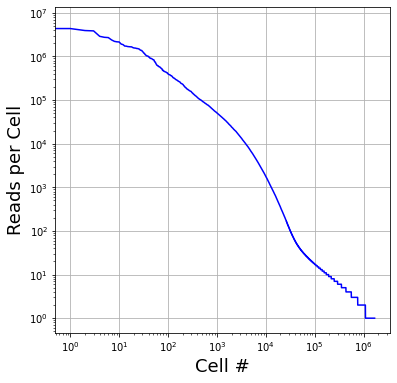

In [6]:
# plot log-log reads per cell vs cells
plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='b')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

In [7]:
# set minimum number of reads per cell
#min_reads = 5000
min_reads = 1000
# create dataframe for called cells only
min_reads_df = all_df.loc[(all_df.sum(axis=1) >= min_reads), :]
valid_barcodes = list(min_reads_df.index)

# print stats
print('%d cells called' % len(min_reads_df.index))
frac_cells = min_reads_df.values.sum()/total_reads
print('Fraction of reads belonging to valid cells: %0.4f' % frac_cells)

12958 cells called
Fraction of reads belonging to valid cells: 0.9577


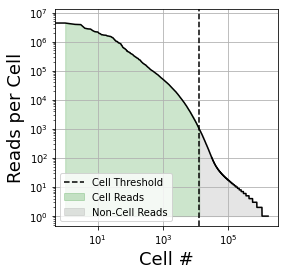

In [8]:
# plot log-log reads per cell vs cells

n_cells =len(min_reads_df.index)
reads_per_cell.sort(reverse=True)

plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='k')
plt.axvline(x=n_cells, color='k', linestyle='--', label='Cell Threshold')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

#t1 = plt.annotate('N' + r'$_{cells}$' + ' = %d' % n_cells, xy=(2,40), fontsize=14)
#t1.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

per_valid = sum(reads_per_cell[0:n_cells]) / sum(reads_per_cell) * 100
#t2 = plt.annotate('%% reads assigned\nto valid cells = %0.1f%%' % per_valid, xy=(2,9), fontsize=14)
#t2.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

#t3 = plt.annotate('Mean reads/cell = %d' % np.mean(reads_per_cell[:n_cells]), xy=(2,4), fontsize=14)
#t3.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

# fill auc
plt.fill_between(range(1, n_cells), reads_per_cell[1:n_cells], [1] * (n_cells - 1), color='g', alpha=0.2, label='Cell Reads')
total_barcodes = len(reads_per_cell)
plt.fill_between(range(n_cells, total_barcodes), reads_per_cell[n_cells:], [1] * (total_barcodes - n_cells), color='grey', alpha=0.2, label='Non-Cell Reads')
plt.legend()
plt.savefig(output_dir + 'ocean-read_per_cell-vs_cell_count.pdf',bbox_inches='tight')

## Barcode profiling with Kraken
use GTDB database


In [11]:
kraken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/'
bracken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/'
fq_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/'
kraken_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/kraken/'


bar_uncls = {}# dictionary of barcode: ratio of unmapped reads

bar_uncls_df = pd.DataFrame(columns=['bar','unclassified_ratio', 'read_count'])

for bar in valid_barcodes:
    fq1 = fq_dir + bar + '_R1.fq'
    fq2 = fq_dir + bar + '_R2.fq'
    rpt = kraken_dir + bar + '.kraken'
    outpt = kraken_dir + bar + '.output'
    #command for the kraken2 analysis of each barcodes
    kraken_cmd =  'kraken2  --threads 32 --memory-mapping  --db {} --report {} --output {} --paired {} {}'.format(kraken_db,
                                                                                                                  rpt, 
                                                                                                                  outpt,
                                                                                                                  fq1,
                                                                                                                  fq2
        
                                                                                                                )
    #os.system(kraken_cmd)
    
    
    # read the first line of the report and get the unmapped read ratio
    rpt_file = open(rpt, "r")
    first_line = rpt_file.readline()
    second_line = rpt_file.readline()
    rpt_file.close()
    uncls_rate = float(first_line.split('\t')[0].strip(' '))
    read_count = int(first_line.split('\t')[1])
    if second_line != '':
        read_count += int(second_line.split('\t')[1])
    bar_uncls_df.loc[len(bar_uncls_df)]=[bar, uncls_rate, read_count]
bar_uncls_df= bar_uncls_df.set_index('bar')
  

In [14]:
bar_uncls_df.to_csv(output_dir + 'ocean_barcode_read_count_and_kraken_unclassified_rate.csv')

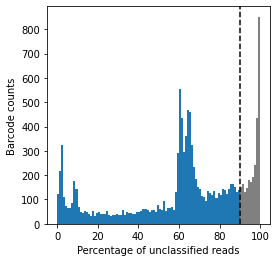

In [23]:
# filter data by unclassified ratio
max_unmap = 90 # select the barcode groups with maxmum 20% read that are not mapped
data = bar_uncls_df['unclassified_ratio'].tolist()

fig, ax = plt.subplots(figsize=(4,4))
N,bins,patches = ax.hist(data, 
                         #edgecolor = 'white', 
                         #linewidth =1,
                         bins =100)
plt.axvline(x=max_unmap, color='k', 
            linestyle='--', 
            label='Cell Threshold')

for i in range(max_unmap,100):    
    patches[i].set_facecolor('grey')
plt.xlabel('Percentage of unclassified reads')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'ocean_filter_by_kraken_ummap_rate.pdf')
plt.show()

In [24]:
filtered_bars =  bar_uncls_df[bar_uncls_df['unclassified_ratio']<=max_unmap].index.tolist()
print(len(filtered_bars))

10291


In [25]:
# bracken analysis of the kraken output files with filtered barcodes. 
bar_gns_abd =  pd.DataFrame() # Dataframe of the genus abundace of each barcode group

for bar in filtered_bars:
    # bracken process the kraken output data
    rpt = kraken_dir + bar + '.kraken'
    brk = kraken_dir + bar + '_G.bracken' # bracken output file at Genus level
    brk_cmd =  'bracken -d {} -l G -i {} -o {}'.format(kraken_db,rpt,brk)
    #print(brk_cmd)
    #os.system(brk_cmd)
    
    # read the bracke output file and combine into a dataframe
    try:
        df = pd.read_csv(brk, sep = '\t', index_col = 0) # read the bracken output into a pd dataframe.
        df = df.rename(columns = {'fraction_total_reads': bar})
        bar_gns_abd = pd.concat([bar_gns_abd, df[bar]], axis =1)
    except FileNotFoundError:
        continue
bar_gns_abd = bar_gns_abd.fillna(0)

In [26]:
bar_gns = bar_gns_abd.T
bar_gns.to_csv(output_dir + 'ocean_filtered_barcode_kraken_genus_abundance.csv')

In [27]:
column_ls = bar_gns.columns.to_list()
bar_gns['purity']=bar_gns[column_ls].max(axis=1)
bar_gns['Genus']=bar_gns[column_ls].idxmax(axis=1)
bar_gns.head()

,g__Azonexus,g__Pseudomonas_E,g__Magnetospirillum_A,g__Komagataeibacter,g__Halioglobus,g__Luminiphilus,g__Pelomonas,g__GCA-002712045,g__Amylibacter,g__Pelagibacter,...,g__J089,g__XYA2-FULL-47-19,g__UBA5359,g__SKKC01,g__AG2,g__Pacificitalea,g__Halopolyspora,g__Abyssicoccus,purity,Genus
TCAGGTGCAATCTACATC-1,0.33103,0.35172,0.31724,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35172,g__Pseudomonas_E
GCGAAGACACCAGTTACG-1,0.00000,0.00000,0.00000,0.0,0.41153,0.02982,0.03976,0.2326,0.04374,0.05368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41153,g__Halioglobus
AGCGGAACAACTACCATC-1,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37590,g__UBA12014
CAACGATCGTTCCGCCAG-1,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.74575,g__Geothrix
TACCATGTATAAGGTGAT-1,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99960,g__Sediminibacterium


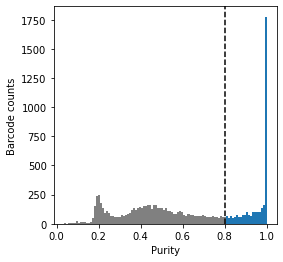

In [28]:
min_purity =0.8

fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=min_purity, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(bar_gns['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'ocean_filter_genuse_level_purity.pdf')

In [31]:
pure_bar_gns = bar_gns[bar_gns['purity']>=min_purity]
#pure_bar_gns = bar_gns[bar_gns['purity']>=0.715]
pure_bar_gns.to_csv(output_dir+'ocean_purity_filtered_genus_matrix.csv')

In [32]:
pure_bar_gns.shape

(3418, 7097)

## UMAP clustering


In [34]:
adata_g =  anndata.AnnData(pure_bar_gns.drop(columns=['purity','Genus']), dtype=np.float32)

In [35]:
sc.pp.neighbors(adata_g, use_rep='X')#, n_neighbors=100)
sc.tl.leiden(adata_g, resolution=1)

In [36]:
sc.tl.umap(adata_g)

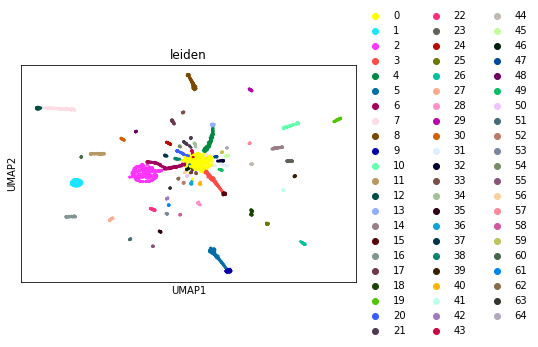

In [37]:
sc.pl.umap(adata_g, color='leiden')

In [38]:
dic_bar_genera= pure_bar_gns['Genus'].to_dict()
gns_cnt=pure_bar_gns['Genus'].value_counts()

dic_bar_genera_fixed ={}
for bar in dic_bar_genera:
    genus = dic_bar_genera[bar] 
    if gns_cnt[genus] <=1: # because the list is too long, if the appearace of genus is less than 10 barcodes, then assign it as other
        dic_bar_genera_fixed[bar] = 'other'
    else:
        dic_bar_genera_fixed[bar]= genus
        
        
adata_g.obs['genus']=adata_g.obs.index.map(dic_bar_genera_fixed).astype('category')
adata_g.obs['genus2']=adata_g.obs.index.map(dic_bar_genera).astype('category')

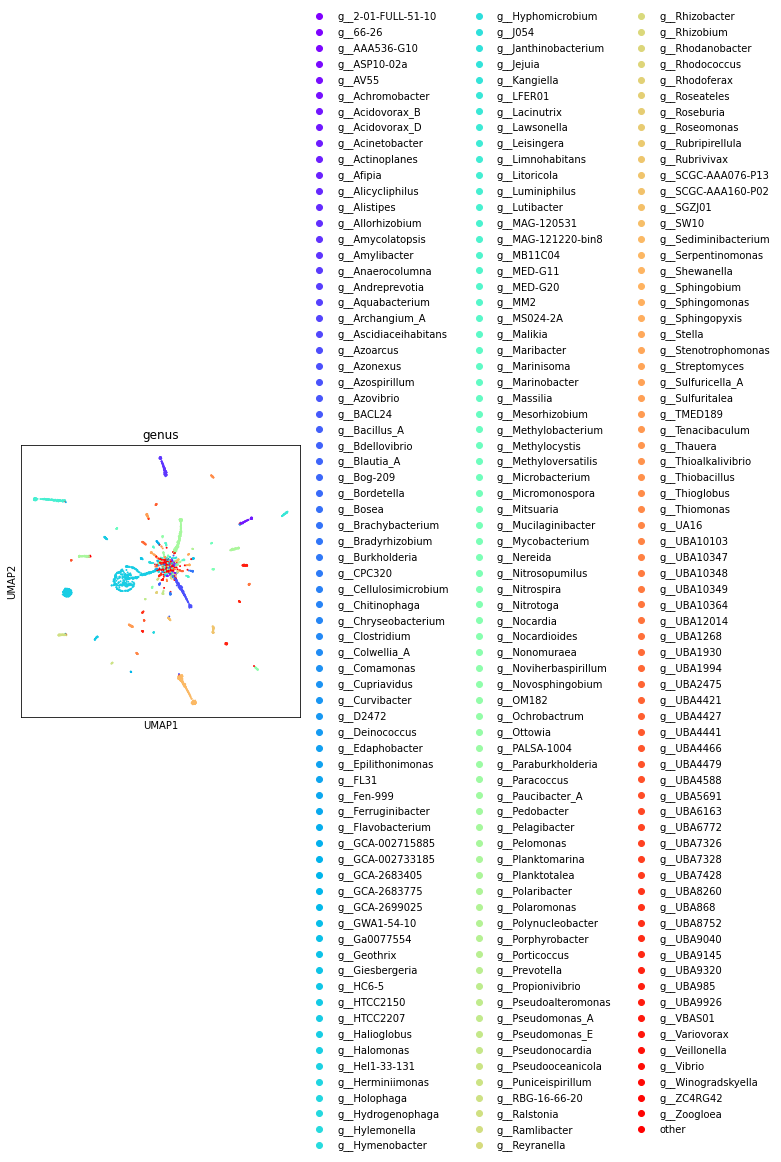

In [39]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_g, 
               color='genus',
               size =15,
               color_map=plt.cm.Reds,
               palette="rainbow")

In [47]:
cluster_df_G_all = adata_g.obs['genus2'].unique().tolist()

pastel1_2000 = pd.read_csv('/drive1/xiangpeng/apps/glasbey/dark2_3000.txt', names = ['color'])['color'].tolist()
pastel1_2000_G_dict = dict(zip(cluster_df_G_all, pastel1_2000[0:0+len(cluster_df_G_all)]))


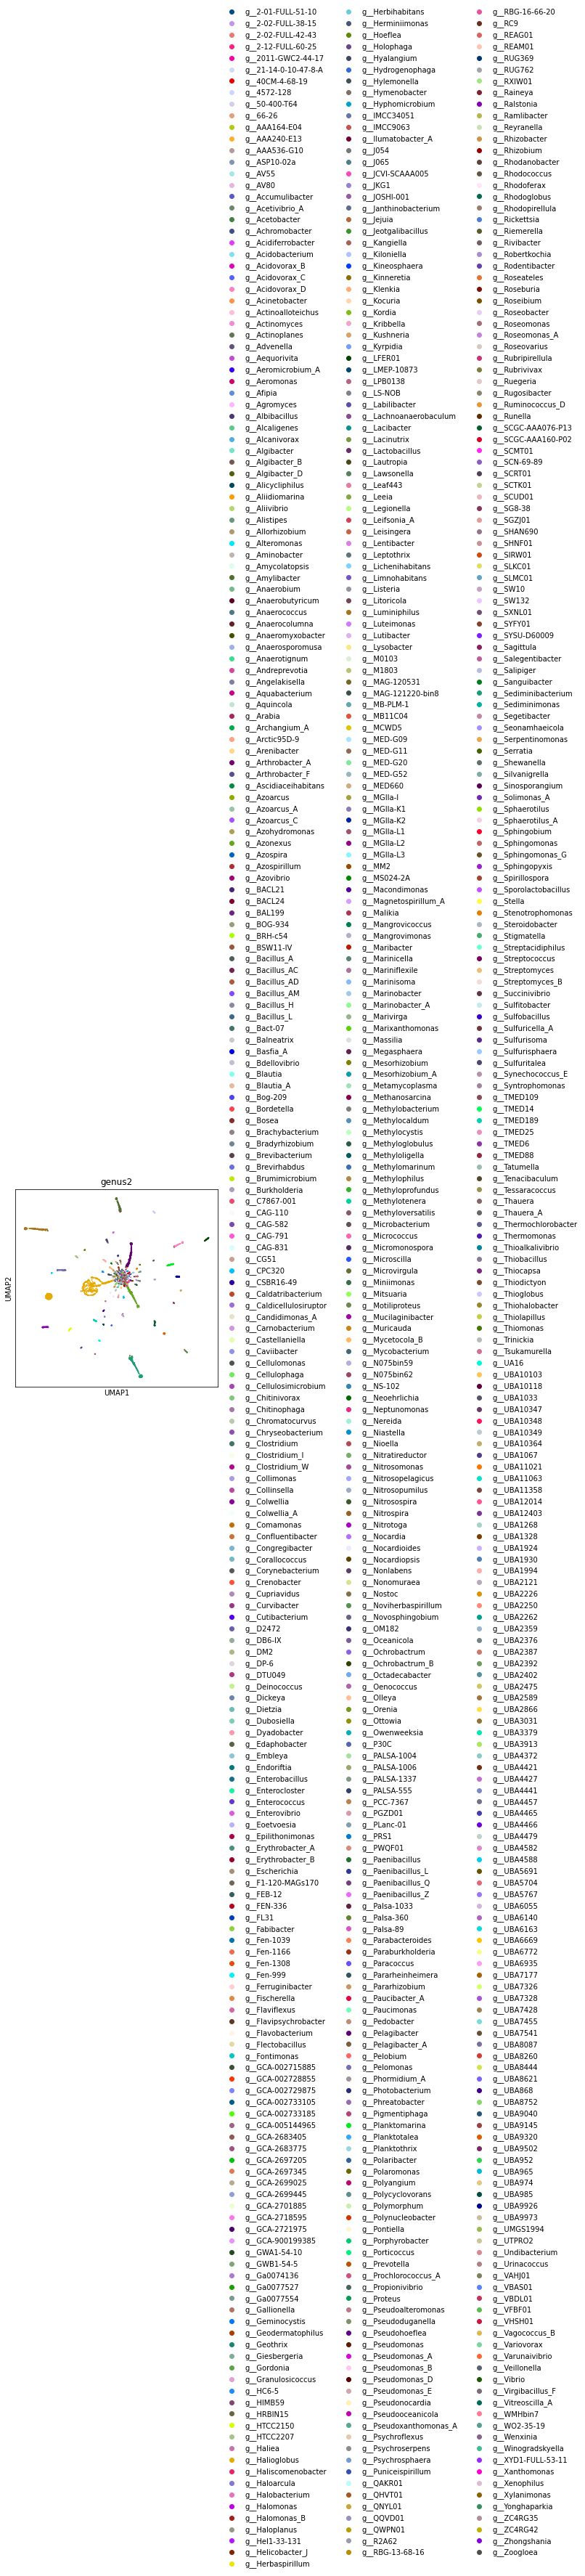

In [48]:

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_g, 
               color='genus2',
               size =15,
               color_map=plt.cm.Reds,
               palette=pastel1_2000_G_dict)

In [49]:
#save the data 
adata_g.write(output_dir + 'ocean_easi-seq_genus_level_filtered_adata_2.h5ad')

### Phylogenetic Tree

In [51]:
cluster_df = adata_g.obs
cluster_df = pd.concat([cluster_df, pd.DataFrame(adata_g.obsm['X_umap'], index=cluster_df.index)],axis =1)
cluster_df = cluster_df.rename(columns={0:'umap_x', 1:'umap_y'})
cluster_df.head()

,leiden,genus,genus2,umap_x,umap_y
TACCATGTATAAGGTGAT-1,5,g__Sediminibacterium,g__Sediminibacterium,11.784434,-22.992294
CTCTCGATACACTGCTTA-1,25,g__UBA9320,g__UBA9320,18.689432,-11.360269
GCCGTGAACTTGATGCTG-1,11,g__Pelomonas,g__Pelomonas,-8.479025,7.225955
GTTAATTCGCTGAGTAGC-1,0,other,g__Neptunomonas,6.643188,4.895752
GCCTTATCTCATTCAGTT-1,15,g__Azonexus,g__Azonexus,11.644830,-3.638283


In [52]:
pure_bar_ls = cluster_df.index.to_list()

In [90]:
# extract the taxa name and NCBI_id that each barcode belongs to 
levels = ['D','P','C','O','F','G', 'S']
header = ['percentage','num_read', 'num_assigned','rank','gtdb_ID', 'name']

name_df = pd.DataFrame(columns = ['bar','D','P','C','O','F','G','S'])

for k in pure_bar_ls:
    taxa_df = pd.read_csv(kraken_dir + k +'.kraken', sep='\t', names = header)
    bar = k.split('_')[0]
    
    name_ls = [bar]

    for l in levels:
        level_df = taxa_df[taxa_df['rank']==l]
        ncbi_id =level_df.loc[level_df.percentage == level_df.percentage.max(), 'gtdb_ID'].values[0]
        name =level_df.loc[level_df.percentage == level_df.percentage.max(), 'name'].values[0].split('__')[-1]
        gtdb_id_ls.append(ncbi_id)
        name_ls.append(name)
    
    name_df.loc[len(name_df)]=name_ls


In [102]:
name_df = name_df.set_index('bar')
name_df.to_csv(output_dir + 'ocean_beach_gtdb_taxa_name_of_barcodes.csv')

In [91]:
## use gtdb metadata to change the gtdb to ncbi id
gtdb_dir ='/drive1/xiangpeng/reference/kraken2/GTDB_release95/from_gtdb/'
gtdb_meta=gtdb_dir+'bac120_metadata_r95.tsv'
gtdb_meta_df = pd.read_csv(gtdb_meta, sep= '\t',
                           on_bad_lines='skip',
                           low_memory=False
                          )

gtdb_meta_ar=gtdb_dir+'ar122_metadata_r95.tsv'
gtdb_meta_df_ar = pd.read_csv(gtdb_meta_ar, sep= '\t',
                           on_bad_lines='skip',
                              low_memory=False
                          )

In [92]:
gtdb_meta_df = gtdb_meta_df.loc[:,[ 'gtdb_taxonomy','ncbi_taxid', ]]
gtdb_meta_df['ncbi_taxid'] = gtdb_meta_df['ncbi_taxid'].apply(int)
gtdb_meta_df[['D','P','C','O','F','G', 'S']]=gtdb_meta_df['gtdb_taxonomy'].str.split(';', expand=True)

gtdb_meta_df['S']=gtdb_meta_df['S'].str.replace('s__', '')
gtdb_meta_df['G']=gtdb_meta_df['G'].str.replace('g__', '')

gtdb_meta_df= gtdb_meta_df.set_index('G')

gtdb_to_ncbi_dict = gtdb_meta_df['ncbi_taxid'].to_dict()

In [93]:
gtdb_meta_df_ar = gtdb_meta_df_ar.loc[:,[ 'gtdb_taxonomy','ncbi_taxid', ]]
gtdb_meta_df_ar=gtdb_meta_df_ar[gtdb_meta_df_ar['ncbi_taxid']!='none']
gtdb_meta_df_ar['ncbi_taxid'] = gtdb_meta_df_ar['ncbi_taxid'].apply(int)

gtdb_meta_df_ar[['D','P','C','O','F','G', 'S']]=gtdb_meta_df_ar['gtdb_taxonomy'].str.split(';', expand=True)

gtdb_meta_df_ar['S']=gtdb_meta_df_ar['S'].str.replace('s__', '')
gtdb_meta_df_ar['G']=gtdb_meta_df_ar['G'].str.replace('g__', '')

gtdb_meta_df_ar= gtdb_meta_df_ar.set_index('G')

gtdb_to_ncbi_dict_ar = gtdb_meta_df_ar['ncbi_taxid'].to_dict()

In [103]:
name_df['ncbi_id_g']=name_df['G'].map(gtdb_to_ncbi_dict)
name_df.loc[name_df['D']=='Archaea','ncbi_id_g']=name_df[name_df['D']=='Archaea'].G.map(gtdb_to_ncbi_dict_ar)

In [104]:
name_df['ncbi_id_g'] = name_df['ncbi_id_g'].astype(int)
genus_id_ls = name_df['ncbi_id_g'].unique().tolist()
print(*genus_id_ls, sep = ', ')
# copy the list into https://phylot.biobyte.de/
# generate the tree using setting ncbi taxa id

413434, 1898104, 1482074, 619304, 146940, 2562682, 745014, 2565932, 2045, 1002526, 1913989, 1388755, 1689867, 29443, 1904441, 1898207, 2026790, 388401, 1761789, 172733, 1848, 1184609, 2014, 179636, 1158175, 264023, 1410606, 2133950, 2163009, 2015205, 1411685, 1009412, 1121035, 1223802, 1871037, 2571271, 63, 2510331, 2502194, 2201271, 135487, 47886, 1035707, 2026724, 80878, 2026721, 979627, 304, 2052186, 1909294, 546364, 470, 2126672, 1415568, 198312, 2021391, 1896175, 2026780, 1848039, 1881037, 2026800, 2080848, 2511166, 695939, 2026777, 2026739, 2491866, 13689, 1911, 1033743, 1427364, 216903, 487796, 74426, 2510334, 1797403, 716813, 1842540, 1978231, 644220, 180197, 2026735, 2026725, 2050896, 1809, 105219, 487797, 1300915, 96345, 1500264, 2495591, 1009426, 1262133, 2026771, 2024894, 1872711, 1849719, 1938756, 1688639, 2478468, 2024858, 80880, 1869212, 1884383, 2021370, 1881035, 2570229, 2231053, 2496867, 225324, 2320855, 1036182, 721133, 354630, 2508719, 2026801, 65786, 1797794, 13815

In [109]:
name_df['read_count'] = bar_uncls_df['read_count']

In [110]:
name_df.head()

,D,P,C,O,F,G,S,ncbi_id_g,read_count
bar,,,,,,,,,
TACCATGTATAAGGTGAT-1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Sediminibacterium,Sediminibacterium magnilacihabitans,413434,47616
CTCTCGATACACTGCTTA-1,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,UBA9320,MAR-2010-188 sp900104375,1898104,1025
GCCGTGAACTTGATGCTG-1,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Hartmannibacter,Hartmannibacter diazotrophicus,1482074,35442
GTTAATTCGCTGAGTAGC-1,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Nitrincolaceae,Neptunomonas,Neptunomonas japonica,619304,3940
GCCTTATCTCATTCAGTT-1,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Rhodocyclaceae,Azonexus,Azonexus denitrificans,146940,1652


In [122]:
# the total read count that are assigned to a specific ncbi ID
tree_read_cnt = name_df.groupby(['ncbi_id_g'])['read_count'].sum()
tree_read_cnt.to_csv(output_dir +'ocean_tree_read_count.csv')
# the total barcode count that are assigned to a specific ncbi ID
tree_bar_cnt = name_df.groupby(['ncbi_id_g'])['read_count'].size()
tree_bar_cnt.to_csv(output_dir +'ocean_tree_bar_count.csv')

# those two files are used to generate the tree annotation file to plot figure 5b.


### Halioglobus single cell pathway analysis 
Halioglobus is the most abundance genus in the EASi-seq dataset. We use Halioglobus as an example to demostrate the single cell pathway analysis ability of EASi-seq. 

In [135]:
h_bar_list = cluster_df[cluster_df['genus']=='g__Halioglobus'].index.to_list()

In [139]:
fq_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/'
Halioglobus_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/'
gene_fam_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/'
fa_dir = Halioglobus_dir + 'fa/'
humann_outdir = Halioglobus_dir + 'humann/'
n =1
for bar in h_bar_list:
    print('processing barcode # {} of {}, {}'.format(n, len(h_bar_list), bar))
    r1 = fq_dir + bar + '_R1.fastq'
    r2 = fq_dir + bar + '_R2.fastq'
    fa = fa_dir + bar + '.fa'
    any2fa_cmd = 'any2fasta {} {} > {}'.format(r1, r2, fa)
    print(any2fa_cmd)
    #os.system(any2fa_cmd)
    bar_humann =  humann_outdir + bar 
    humann_cmd ='humann --input {} --output {} --search-mode uniref90 --threads 32'.format(fa, bar_humann)
    print(humann_cmd)
    #os.system(humann_cmd)
    
    # copy the genefamilies output file into gene_fam_dir
    bar_gfam_file = bar_humann + '/' + bar + '_genefamilies.tsv'
    cp_cmd = 'cp {} {}'.format(bar_gfam_file, gene_fam_dir)
    print(cp_cmd)
    #os.system(cp_cmd)
    n+=1

processing barcode # 1 of 810, TCACGCGACACCAGCGTT-1
any2fasta /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/TCACGCGACACCAGCGTT-1_R1.fastq /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/TCACGCGACACCAGCGTT-1_R2.fastq > /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/fa/TCACGCGACACCAGCGTT-1.fa
humann --input /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/fa/TCACGCGACACCAGCGTT-1.fa --output /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/TCACGCGACACCAGCGTT-1 --search-mode uniref90 --threads 32
cp /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/TCACGCGACACCAGCGTT-1/TCACGCGACACCAGCGTT-1_genefamilies.tsv /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/
processing barcode # 2 of 810, TCACGCGACTCATCATCT-1
any2fasta /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/TCACGCGACTCATCATCT-1_R1.fastq /dr

processing barcode # 568 of 810, TCACGCGACAGTGATGCG-1
any2fasta /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/TCACGCGACAGTGATGCG-1_R1.fastq /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/TCACGCGACAGTGATGCG-1_R2.fastq > /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/fa/TCACGCGACAGTGATGCG-1.fa
humann --input /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/fa/TCACGCGACAGTGATGCG-1.fa --output /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/TCACGCGACAGTGATGCG-1 --search-mode uniref90 --threads 32
cp /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/TCACGCGACAGTGATGCG-1/TCACGCGACAGTGATGCG-1_genefamilies.tsv /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/
processing barcode # 569 of 810, AGAAGTCCTGGATTACGC-1
any2fasta /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/AGAAGTCCTGGATTACGC-1_R1.fastq

In [140]:
# join all genefamilies output file using humann_join_tables command
! humann_join_tables -i /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/ -o /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/gfam_all.tsv


In [141]:
gfam_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/'
gfam_file = gfam_dir+ 'gfam_all.tsv'
gfam_df = pd.read_csv(gfam_file, index_col =0, sep = '\t')

In [142]:
gfam_df = gfam_df.drop('UNMAPPED')

In [144]:

gfam_df['gene_fam'] =[x.split('|')[0] for x in gfam_df.index]
gfam_df = gfam_df.drop_duplicates(subset=['gene_fam']).drop(columns='gene_fam')

In [155]:
min_cell_cnt = 5
min_gene_cnt = 5
filtered_gfam = gfam_df.astype(bool).loc[(gfam_df.astype(bool).sum(axis=1) >= min_cell_cnt),(gfam_df.astype(bool).sum(axis=0) >= min_gene_cnt)].astype(int)

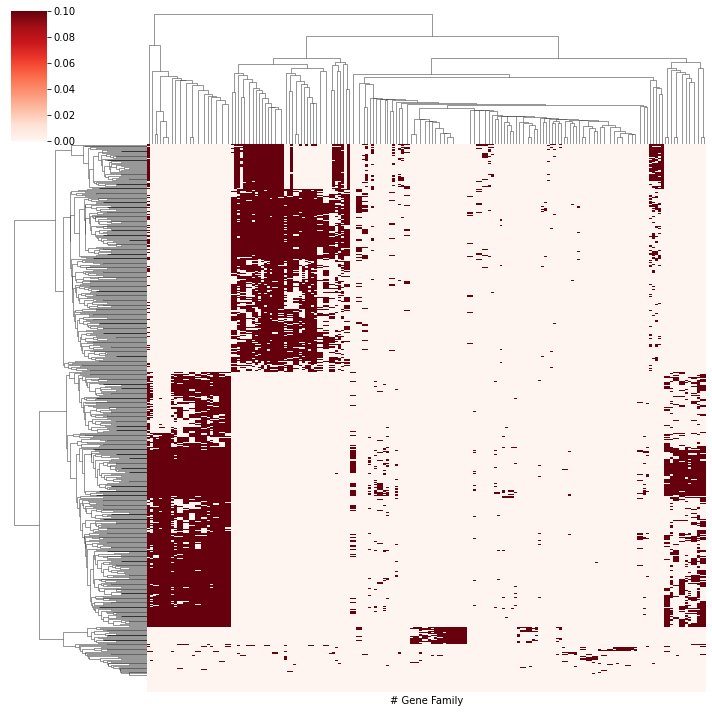

In [172]:
g=sns.clustermap(filtered_gfam.T, 
               figsize=(10,10),
                 yticklabels=False,
                 xticklabels=False,
                cmap='Reds',
                vmax=0.1)

In [163]:
reordered_gfam = filtered_gfam.iloc[g.dendrogram_col.reordered_ind, g.dendrogram_row.reordered_ind]

In [165]:
adata_t = anndata.AnnData(reordered_gfam.T, dtype=np.float32)

In [166]:
sc.pp.neighbors(adata_t, use_rep='X')
sc.tl.leiden(adata_t, resolution=0.2)

In [167]:
sc.tl.umap(adata_t)

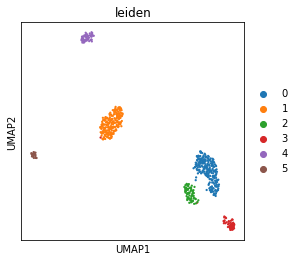

In [168]:
with plt.rc_context({"figure.figsize": (4, 4), }):
    sc.pl.umap(adata_t, 
               color='leiden', 
               size =20, 
               frameon= True,
               save = 'Halioglobus_subclustering_by_genes_umap_v2.pdf'
              )

plt.show()

         Falling back to preprocessing with `sc.pp.pca` and default params.


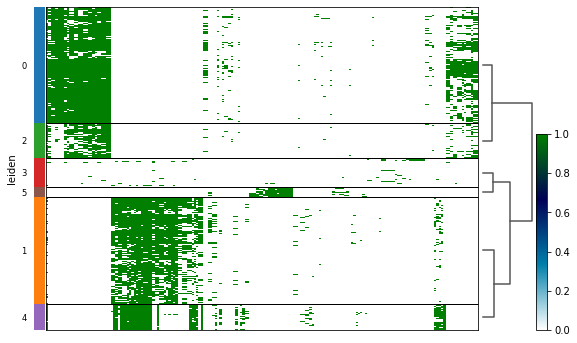

In [169]:

ax = sc.pl.heatmap(adata_t, 
                       adata_t.var_names, 
                       groupby='leiden', 
                       dendrogram=True,
                   cmap='ocean_r',
                       save ='Halioglobus_subclustering_by_genes_heatmap_v2.pdf')
#plt.savefig(out_dir+'Halioglobus_subclustering_by_genes_heatmap.pdf', bbox_inches='tight') 
plt.show()

In [170]:
adata_t.write(output_dir + 'ocean_easi-seq_halioglobus_gfam.h5ad')